In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._


//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//Circe para trabajar con JSON
import $ivy.`com.softwaremill.sttp.client::async-http-client-backend-monix:2.0.0-RC2`
import sttp.client.quick.{quickRequest, UriContext, backend}
import sttp.client.asynchttpclient.monix._


//Sttp para realizar request
import $ivy.`com.softwaremill.sttp.client::async-http-client-backend-monix:2.0.0-RC2`
import sttp.client.quick.{quickRequest, UriContext, backend}
import sttp.client.asynchttpclient.monix._
import sttp.client.basicRequest

//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._

import $ivy.$                                  



import org.apache.spark.sql._

import org.apache.spark.sql.functions._


//Reducir numero logs

import org.apache.log4j.{Level, Logger}

import $ivy.$                                                                        

import sttp.client.quick.{quickRequest, UriContext, backend}

import sttp.client.asynchttpclient.monix._


//Sttp para realizar request

import $ivy.$                                                                        

import sttp.client.quick.{quickRequest, UriContext, backend}

import sttp.client.asynchttpclient.monix._

import sttp.client.basicRequest

//For adding extra dependenies

import $ivy.$                               

//Plotly

import $ivy.$                                      

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._

In [2]:
//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
    .master("local[*]")
    .getOrCreate()
}
import spark.implicits._

Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

spark: SparkSession = org.apache.spark.sql.SparkSession@62db4ed9
import spark.implicits._

## Creación de metodos para analisis

In [3]:
//Crear URL
def createUri(category: String, widget: String, start_date: String, end_date: String, time_trunc: String, lang: String, 
              geo_trunc: String = "", geo_limit: String = "", geo_ids: String = ""): String = {
  val baseUrl = s"https://apidatos.ree.es/$lang/datos/$category/$widget"
  
  // Crear un mapa con los parámetros obligatorios y opcionales
  val params = Map(
    "start_date" -> start_date,
    "end_date" -> end_date,
    "time_trunc" -> time_trunc,
    "geo_trunc" -> geo_trunc,
    "geo_limit" -> geo_limit,
    "geo_ids" -> geo_ids
  ).filter { case (_, v) => v.nonEmpty } // Filtrar los parámetros que no están vacíos

  //Especifico el orden concreto de los paramtros ya que, Scala map no te garantiza el orden
  val orderedKeys = Seq("start_date", "end_date", "time_trunc", "geo_trunc", "geo_limit", "geo_ids")

  // Unir los parámetros en una cadena
  val queryString = orderedKeys.flatMap(key => params.get(key).map(value => s"$key=$value")).mkString("&")
  
  s"$baseUrl?$queryString"
}


//Lanzar llamada y obtener guardar datos
def getDataApi(apiUrl: String): Either[String, String] = {
 
    val newRequest = basicRequest.get(uri"$apiUrl")
    val response = newRequest.send()
  
  response.body match {
    case Right(body) => 
      Right(body)
      
    case Left(error) => 
      Left(s"Error fetching data: $error")
  }
}

// Transformar response a DataFrame
def responseToDF(response: Either[String, String]): DataFrame = {
    response match {
    case Right(body) => 
        val rdd = spark.sparkContext.parallelize(Seq(body))
        spark.read.json(rdd)
    case Left(error) => 
        println(error)
        spark.emptyDataFrame
    }
}



defined function createUri
defined function getDataApi
defined function responseToDF

### Creamos Uris

In [4]:
val category = "generacion"
val category2 = "demanda"
val widget = "estructura-generacion"
val start_date = "2023-01-01T00:00"
val end_date = "2023-12-31T23:59"
val time_trunc = "month"
val lang = "es"
val geo_trunc = "electric_system"
val geo_limit = "ccaa"
val geo_ids = "13"
val uriGeneracionNacional23 = createUri(category, widget, start_date, end_date, time_trunc, lang) //Generacion Nacional
val uriGeneracionMadrid23 = createUri(category,widget,start_date, end_date, time_trunc, lang, geo_trunc, geo_limit, geo_ids) //Generacion en comunidad de Madrid
val uriDemandaMadrid23 = createUri("demanda","evolucion",start_date, end_date, time_trunc, lang, geo_trunc, geo_limit, geo_ids) //Demanda en comunidad de Madrid

category: String = "generacion"
category2: String = "demanda"
widget: String = "estructura-generacion"
start_date: String = "2023-01-01T00:00"
end_date: String = "2023-12-31T23:59"
time_trunc: String = "month"
lang: String = "es"
geo_trunc: String = "electric_system"
geo_limit: String = "ccaa"
geo_ids: String = "13"
uriGeneracionNacional23: String = "https://apidatos.ree.es/es/datos/generacion/estructura-generacion?start_date=2023-01-01T00:00&end_date=2023-12-31T23:59&time_trunc=month"
uriGeneracionMadrid23: String = "https://apidatos.ree.es/es/datos/generacion/estructura-generacion?start_date=2023-01-01T00:00&end_date=2023-12-31T23:59&time_trunc=month&geo_trunc=electric_system&geo_limit=ccaa&geo_ids=13"
uriDemandaMadrid23: String = "https://apidatos.ree.es/es/datos/demanda/evolucion?start_date=2023-01-01T00:00&end_date=2023-12-31T23:59&time_trunc=month&geo_trunc=electric_system&geo_limit=ccaa&geo_ids=13"

### Hacemos llamada a la api

In [5]:
val jsonGeneracionNacional23 = getDataApi(uriGeneracionNacional23)
val jsonGeneracionMadrid23 = getDataApi(uriGeneracionMadrid23)
val jsonDemandaMadrid23 = getDataApi(uriDemandaMadrid23)

jsonGeneracionNacional23: Either[String, String] = Right(
  "{\"data\":{\"type\":\"Generaci\\u00f3n por tecnolog\\u00eda\",\"id\":\"gen1\",\"attributes\":{\"title\":\"Generaci\\u00f3n por tecnolog\\u00eda\",\"last-update\":\"2024-05-27T14:20:05.000+02:00\",\"description\":null},\"meta\":{\"cache-control\":{\"cache\":\"HIT\",\"expireAt\":\"2024-07-26T15:46:13\"}}},\"included\":[{\"type\":\"Hidr\\u00e1ulica\",\"id\":\"10288\",\"groupId\":\"1\",\"attributes\":{\"title\":\"Hidr\\u00e1ulica\",\"description\":null,\"color\":\"#0090d1\",\"type\":\"Renovable\",\"magnitude\":null,\"composite\":false,\"last-update\":\"2024-05-27T14:20:01.000+02:00\",\"values\":[{\"value\":3859362.995,\"percentage\":0.16176383781768447,\"datetime\":\"2023-01-01T00:00:00.000+01:00\"},{\"value\":2462733.917,\"percentage\":0.11326987124718617,\"datetime\":\"2023-02-01T00:00:00.000+01:00\"},{\"value\":2044472.686,\"percentage\":0.08516580607060466,\"datetime\":\"2023-03-01T00:00:00.000+01:00\"},{\"value\":1533648.466

### Crear Dataframes

In [6]:
val dfGeneracionNacional23 = responseToDF(jsonGeneracionNacional23)
val dfGeneracionMadrid23 = responseToDF(jsonGeneracionMadrid23)
val dfDemandaMadrid23 = responseToDF(jsonDemandaMadrid23)

json at cmd2.sc:45

8 / 8

json at cmd2.sc:45

8 / 8

json at cmd2.sc:45

8 / 8

dfGeneracionNacional23: DataFrame = [data: struct<attributes: struct<description: string, last-update: string ... 1 more field>, id: string ... 2 more fields>, included: array<struct<attributes:struct<color:string,composite:boolean,description:string,last-update:string,magnitude:string,title:string,type:string,values:array<struct<datetime:string,percentage:double,value:double>>>,groupId:string,id:string,type:string>>]
dfGeneracionMadrid23: DataFrame = [data: struct<attributes: struct<description: string, last-update: string ... 1 more field>, id: string ... 2 more fields>, included: array<struct<attributes:struct<color:string,composite:boolean,description:string,last-update:string,magnitude:string,title:string,type:string,values:array<struct<datetime:string,percentage:double,value:double>>>,groupId:string,id:string,type:string>>]
dfDemandaMadrid23: DataFrame = [data: struct<attributes: struct<description: string, last-update: string ... 1 more field>, id: string ... 2 more fields>, inc

In [23]:
val dfFinalGeneracion23Nacional = dfGeneracionNacional23
                    .withColumn("included", explode($"included"))
                    .withColumn("valores", explode($"included.attributes.values"))
                    .select(
                        $"included.type".as("TipoEnergia"),
                        $"included.attributes.type" .as("FamiliaEnergia"),
                        $"valores.*"
                    )

val dfFinalGeneracion23Madrid = dfGeneracionMadrid23
                    .withColumn("included", explode($"included"))
                    .withColumn("valores", explode($"included.attributes.values"))
                    .select(
                        $"included.type".as("TipoEnergia"),
                        $"included.attributes.type" .as("FamiliaEnergia"),
                        $"valores.*"
                    )
val dfFinalDemanda23Madrid = dfDemandaMadrid23
                    .withColumn("included", explode($"included"))
                    .withColumn("valores", explode($"included.attributes.values"))
                    .select("valores.*")
    
val fecha = dfFinalGeneracion23Madrid
                .filter($"TipoEnergia" === "Generación total")
                .select($"datetime").as[String].collect.toSeq  

val generacionNacional = dfFinalGeneracion23Nacional
                .filter($"TipoEnergia" === "Generación total")
                .select($"value").as[Double].collect.toSeq

val generacionMadrid = dfFinalGeneracion23Madrid
                .filter($"TipoEnergia" === "Generación total")
                .select($"value").as[Double].collect.toSeq

val demandaMadrid = dfFinalDemanda23Madrid
                .select($"value").as[Double].collect.toSeq

collect at cmd22.sc:25

8 / 8

collect at cmd22.sc:29

8 / 8

collect at cmd22.sc:33

8 / 8

collect at cmd22.sc:36

8 / 8

dfFinalGeneracion23Nacional: DataFrame = [TipoEnergia: string, FamiliaEnergia: string ... 3 more fields]
dfFinalGeneracion23Madrid: DataFrame = [TipoEnergia: string, FamiliaEnergia: string ... 3 more fields]
dfFinalDemanda23Madrid: DataFrame = [datetime: string, percentage: bigint ... 1 more field]
fecha: Seq[String] = WrappedArray(
  "2023-01-01T00:00:00.000+01:00",
  "2023-02-01T00:00:00.000+01:00",
  "2023-03-01T00:00:00.000+01:00",
  "2023-04-01T00:00:00.000+02:00",
  "2023-05-01T00:00:00.000+02:00",
  "2023-06-01T00:00:00.000+02:00",
  "2023-07-01T00:00:00.000+02:00",
  "2023-08-01T00:00:00.000+02:00",
  "2023-09-01T00:00:00.000+02:00",
  "2023-10-01T00:00:00.000+02:00",
  "2023-11-01T00:00:00.000+01:00",
  "2023-12-01T00:00:00.000+01:00"
)
generacionNacional: Seq[Double] = WrappedArray(
  2.385800836E7,
  2.1742179891999997E7,
  2.4005792701999996E7,
  2.1471225893000003E7,
  2.1519730996E7,
  2.1316832239E7,
  2.3674368509999998E7,
  2.3548672123000003E7,
  2.0776975917E7,
  2.0

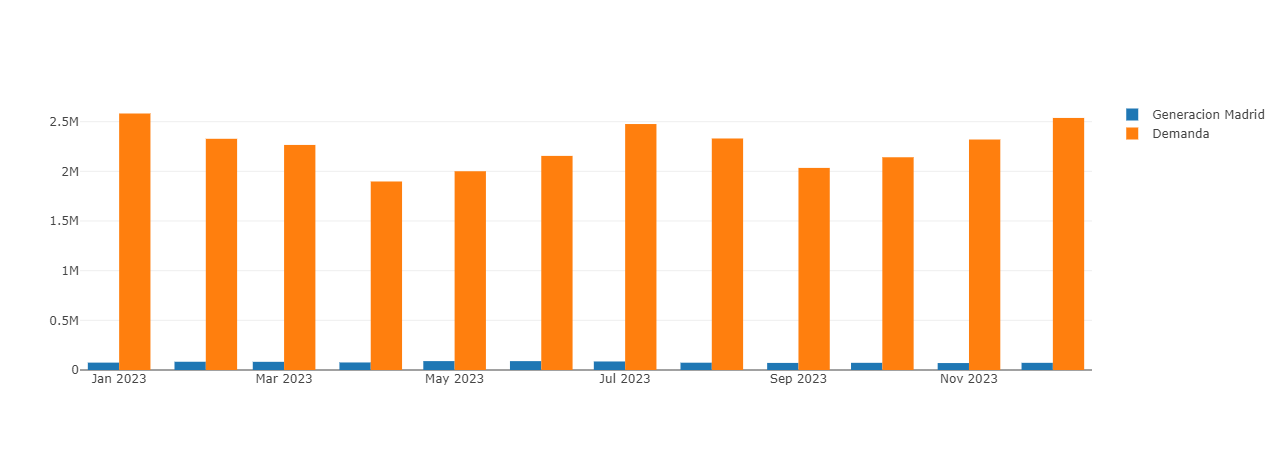

GeneracionNacional: Bar = Bar(
  Strings(
    WrappedArray(
      "2023-01-01T00:00:00.000+01:00",
      "2023-02-01T00:00:00.000+01:00",
      "2023-03-01T00:00:00.000+01:00",
      "2023-04-01T00:00:00.000+02:00",
      "2023-05-01T00:00:00.000+02:00",
      "2023-06-01T00:00:00.000+02:00",
      "2023-07-01T00:00:00.000+02:00",
      "2023-08-01T00:00:00.000+02:00",
      "2023-09-01T00:00:00.000+02:00",
      "2023-10-01T00:00:00.000+02:00",
      "2023-11-01T00:00:00.000+01:00",
      "2023-12-01T00:00:00.000+01:00"
    )
  ),
  Doubles(
    WrappedArray(
      2.385800836E7,
      2.1742179891999997E7,
      2.4005792701999996E7,
      2.1471225893000003E7,
      2.1519730996E7,
      2.1316832239E7,
      2.3674368509999998E7,
      2.3548672123000003E7,
      2.0776975917E7,
      2.096983524000001E7,
      2.164125295E7,
      2.2595187450999998E7
    )
  ),
  Some("Generacion Espa\u00f1a"),
  None,
  None,
  None,
  None,
  None,
...
GeneracionMadrid: Bar = Bar(
  Strings(
  

In [8]:
val GeneracionNacional = Bar(
  fecha,
  generacionNacional,
  name = "Generacion España"
)
val GeneracionMadrid = Bar(
  fecha,
  generacionMadrid,
  name = "Generacion Madrid"
)

val Demanda = Bar(
  fecha,
  demandaMadrid,
  name = "Demanda"
)

val data = Seq(GeneracionMadrid, Demanda)

val layout = Layout( 
  barmode = BarMode.Group
)

plot(data, layout)

In [9]:
    
val fecha = dfFinalGeneracion23Madrid
                .filter($"TipoEnergia" === "Generación total")
                .select($"value").as[String].collect.toSeq  

collect at cmd8.sc:3

8 / 8

fecha: Seq[String] = WrappedArray(
  "74281.963",
  "83070.997",
  "82359.38699999999",
  "75922.93199999999",
  "89598.51699999999",
  "89449.49699999999",
  "85841.09599999999",
  "73522.84400000001",
  "71274.86100000002",
  "72290.571",
  "70002.158",
  "72193.419"
)

In [10]:
val geo_ids = "16"
val uriGeneracionAsturias23 = createUri(category,widget,start_date, end_date, time_trunc, lang, geo_trunc, geo_limit, geo_ids) //Generacion en comunidad de Madrid
val uriDemandaAsturias23 = createUri("demanda","evolucion",start_date, end_date, time_trunc, lang, geo_trunc, geo_limit, geo_ids) //Demanda en comunidad de Madrid


val jsonGeneracionAsturias23 = getDataApi(uriGeneracionAsturias23)
val jsonDemandaAsturias23 = getDataApi(uriDemandaAsturias23)


val dfGeneracionAsturias23 = responseToDF(jsonGeneracionAsturias23)
val dfDemandaAsturias23 = responseToDF(jsonDemandaAsturias23)

val dfFinalGeneracion23Asturias = dfGeneracionAsturias23
                    .withColumn("included", explode($"included"))
                    .withColumn("valores", explode($"included.attributes.values"))
                    .select(
                        $"included.type".as("TipoEnergia"),
                        $"included.attributes.type" .as("FamiliaEnergia"),
                        $"valores.*"
                    )
val dfFinalDemanda23Asturias = dfDemandaAsturias23
                    .withColumn("included", explode($"included"))
                    .withColumn("valores", explode($"included.attributes.values"))
                    .select("valores.*")

json at cmd2.sc:45

8 / 8

json at cmd2.sc:45

8 / 8

geo_ids: String = "16"
uriGeneracionAsturias23: String = "https://apidatos.ree.es/es/datos/generacion/estructura-generacion?start_date=2023-01-01T00:00&end_date=2023-12-31T23:59&time_trunc=month&geo_trunc=electric_system&geo_limit=ccaa&geo_ids=16"
uriDemandaAsturias23: String = "https://apidatos.ree.es/es/datos/demanda/evolucion?start_date=2023-01-01T00:00&end_date=2023-12-31T23:59&time_trunc=month&geo_trunc=electric_system&geo_limit=ccaa&geo_ids=16"
jsonGeneracionAsturias23: Either[String, String] = Right(
  "{\"data\":{\"type\":\"Generaci\\u00f3n por tecnolog\\u00eda\",\"id\":\"gen1\",\"attributes\":{\"title\":\"Generaci\\u00f3n por tecnolog\\u00eda\",\"last-update\":\"2024-05-27T14:20:05.000+02:00\",\"description\":null},\"meta\":{\"cache-control\":{\"cache\":\"HIT\",\"expireAt\":\"2024-07-26T17:36:20\"}}},\"included\":[{\"type\":\"Hidr\\u00e1ulica\",\"id\":\"10330\",\"groupId\":\"1\",\"attributes\":{\"title\":\"Hidr\\u00e1ulica\",\"description\":null,\"color\":\"#0090d1\",\"type\":

collect at cmd11.sc:3

8 / 8

collect at cmd11.sc:6

8 / 8

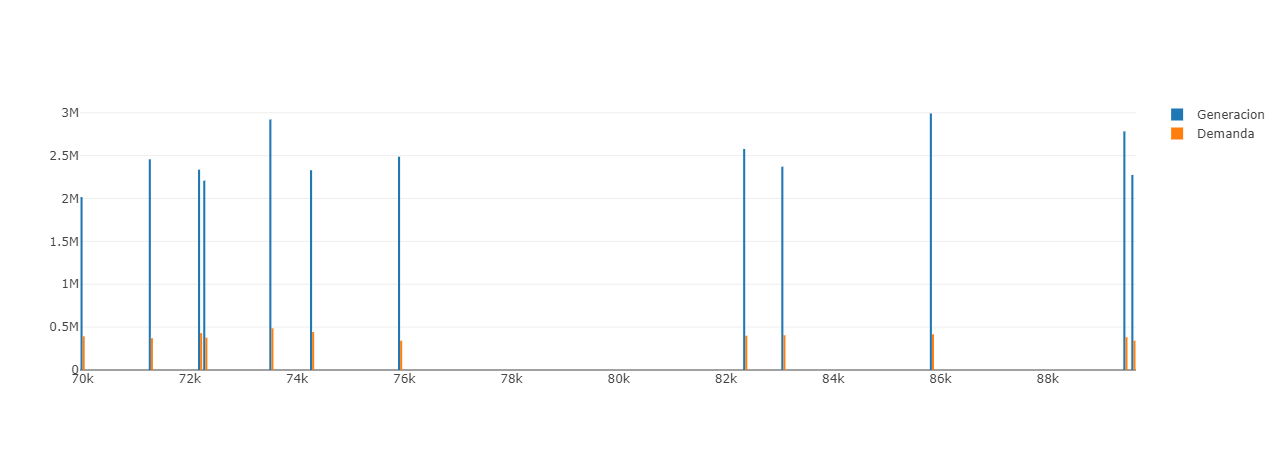

generacionAsturias: Seq[Double] = WrappedArray(
  2329617.2980000004,
  2370071.3319999995,
  2577800.425,
  2487521.485,
  2275025.256,
  2781431.1280000005,
  2991283.9919999996,
  2920043.7939999993,
  2456561.955,
  2207613.297,
  2016277.7539999997,
  2336376.015
)
demandaAsturias: Seq[Double] = WrappedArray(
  442676.722,
  404495.391,
  399112.191,
  341414.443,
  341659.083,
  381372.379,
  416035.901,
  484804.526,
  370020.846,
  375786.632,
  391953.037,
  429643.512
)
GeneracionAsturias: Bar = Bar(
  Strings(
    WrappedArray(
      "74281.963",
      "83070.997",
      "82359.38699999999",
      "75922.93199999999",
      "89598.51699999999",
      "89449.49699999999",
      "85841.09599999999",
      "73522.84400000001",
      "71274.86100000002",
      "72290.571",
      "70002.158",
      "72193.419"
    )
  ),
  Doubles(
    WrappedArray(
      2329617.2980000004,
      2370071.3319999995,
      2577800.425,
      2487521.485,
      2275025.256,
      2781431.128000000

In [12]:
val generacionAsturias = dfFinalGeneracion23Asturias
                .filter($"TipoEnergia" === "Generación total")
                .select($"value").as[Double].collect.toSeq

val demandaAsturias = dfFinalDemanda23Asturias
                .select($"value").as[Double].collect.toSeq
val GeneracionAsturias = Bar(
  fecha,
  generacionAsturias,
  name = "Generacion"
)

val DemandaAsturias = Bar(
  fecha,
  demandaAsturias,
  name = "Demanda"
)

val data = Seq(GeneracionAsturias, DemandaAsturias)

val layout = Layout( 
  barmode = BarMode.Group
)

plot(data, layout)

collect at cmd27.sc:8

8 / 8

collect at cmd27.sc:8

200 / 200

collect at cmd27.sc:11

8 / 8

collect at cmd27.sc:11

200 / 200

67694.9875
939808.2420000001
145259.892
146688.78999999998
67694.9875
421226.97199999995
91242.613


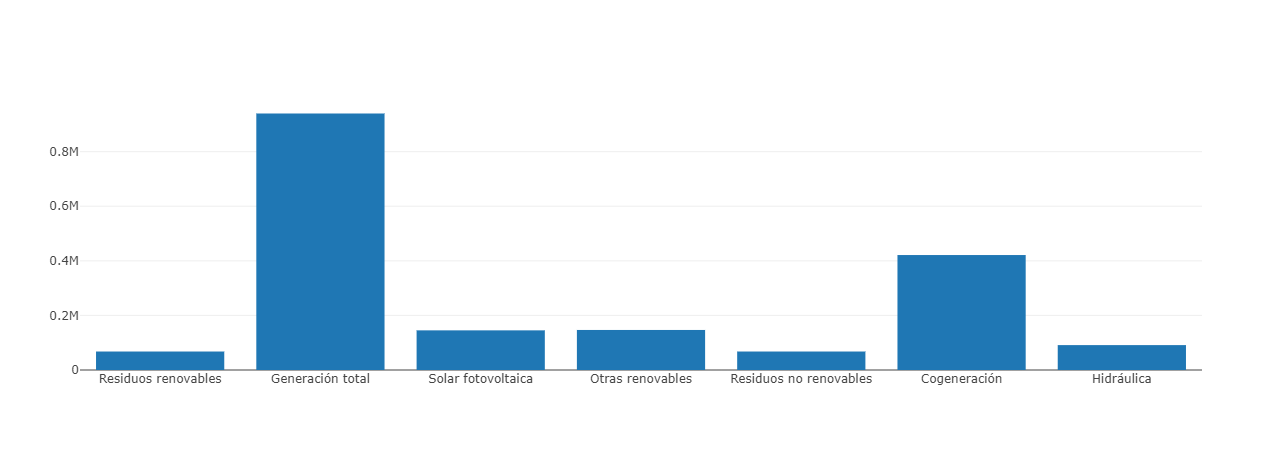

dfGrouped: DataFrame = [TipoEnergia: string, total_value: double]
totalValues: Seq[Double] = WrappedArray(
  67694.9875,
  939808.2420000001,
  145259.892,
  146688.78999999998,
  67694.9875,
  421226.97199999995,
  91242.613
)
tipos: Seq[String] = WrappedArray(
  "Residuos renovables",
  "Generaci\u00f3n total",
  "Solar fotovoltaica",
  "Otras renovables",
  "Residuos no renovables",
  "Cogeneraci\u00f3n",
  "Hidr\u00e1ulica"
)
data: Seq[Bar] = List(
  Bar(
    Strings(
      WrappedArray(
        "Residuos renovables",
        "Generaci\u00f3n total",
        "Solar fotovoltaica",
        "Otras renovables",
        "Residuos no renovables",
        "Cogeneraci\u00f3n",
        "Hidr\u00e1ulica"
      )
    ),
    Doubles(
      WrappedArray(
        67694.9875,
        939808.2420000001,
        145259.892,
        146688.78999999998,
        67694.9875,
        421226.97199999995,
        91242.613
      )
    ),
    None,
    None,
    None,
    None,
    None,
    None,
    None

In [28]:
// Realizar el groupBy y sumar la columna "value"
val dfGrouped = dfFinalGeneracion23Madrid
  .groupBy($"TipoEnergia")
  .agg(sum($"value").alias("total_value"))

// Seleccionar la columna "total_value" y convertirla a Seq[Double]
val totalValues = dfGrouped
  .select($"total_value")
  .as[Double]
  .collect()
  .toSeq
val tipos = dfFinalGeneracion23Madrid.select($"TipoEnergia").distinct().as[String].collect.toSeq
// Mostrar los resultados
totalValues.foreach(println)
val data = Seq(
  Bar(
    tipos,
    totalValues
  )
)

plot(data)

In [27]:
val fechas = dfFinalGeneracion23Madrid.select($"TipoEnergia").distinct().as[String].collect.toSeq

collect at cmd26.sc:1

8 / 8

collect at cmd26.sc:1

200 / 200

fechas: Seq[String] = WrappedArray(
  "Residuos renovables",
  "Generaci\u00f3n total",
  "Solar fotovoltaica",
  "Otras renovables",
  "Residuos no renovables",
  "Cogeneraci\u00f3n",
  "Hidr\u00e1ulica"
)

In [24]:
dfFinalGeneracion23Madrid.show()

show at cmd23.sc:1

1 / 1

show at cmd23.sc:1

4 / 4

show at cmd23.sc:1

3 / 3

+------------------+--------------+--------------------+--------------------+---------+
|       TipoEnergia|FamiliaEnergia|            datetime|          percentage|    value|
+------------------+--------------+--------------------+--------------------+---------+
|        Hidráulica|     Renovable|2023-01-01T00:00:...| 0.16735471839913546|12431.437|
|        Hidráulica|     Renovable|2023-02-01T00:00:...| 0.10323562145281584| 8575.886|
|        Hidráulica|     Renovable|2023-03-01T00:00:...| 0.08038810439422044| 6620.715|
|        Hidráulica|     Renovable|2023-04-01T00:00:...| 0.08393761716157118|  6372.79|
|        Hidráulica|     Renovable|2023-05-01T00:00:...| 0.06378713835185465| 5715.233|
|        Hidráulica|     Renovable|2023-06-01T00:00:...| 0.07703910285823073| 6891.109|
|        Hidráulica|     Renovable|2023-07-01T00:00:...|  0.1232040303865645|10575.969|
|        Hidráulica|     Renovable|2023-08-01T00:00:...| 0.12774391589095763| 9392.096|
|        Hidráulica|     Renovab